# ICA with Spatial Binning (unsuccessful so far) - Gauss Peaks
#### Working with Gaussian random field (GRF) as noise + Gaussian peaks as nonG

## Set parameters

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import modules.peaks as px
import modules.fouriertransform as ft
import modules.correlationfunctions as cf
import modules.gaussianfield as grf
import modules.filters as flt
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats

# Parameters
logtwo_N = 11
size_field = 2**logtwo_N
correlated = False
BoxSize = 512.0
dx = BoxSize/N
h = 0.695
k0 = 0.02 
A0 = (7.96*10**-10)# * 2*np.pi**2)
ns = 0.965
seed = 50
dk = (2*np.pi) / BoxSize # Bin size (for power spectrum)
Pk = lambda k: A0*(k/k0)**(ns-1)*k**-3

# Other NG parameters
alpha = 1.0
nu = 2
c, w = 2, .2

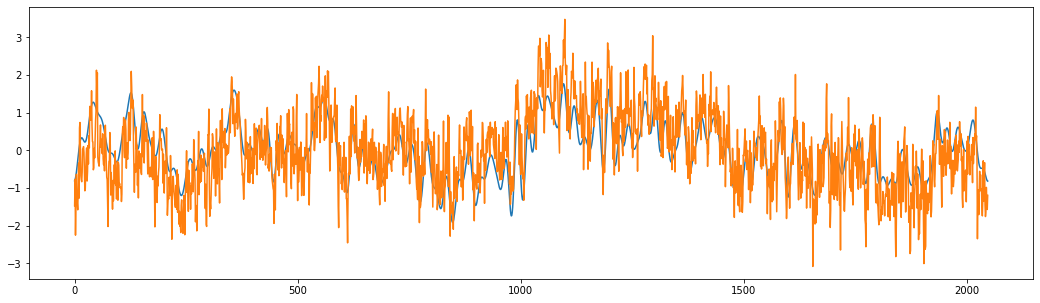

In [27]:
# Generate the grfs using gaussianfield
g = grf.gaussian_random_field_1D(size_field, BoxSize=size_field, seed=50)
kc = np.logspace(0, logtwo_N-1, num=10, base=2.0)
kc_size = kc.size

f = grf.window(g, N, kc[0], kc[6])

plt.figure(figsize=(18,5))
plt.plot(f)
plt.plot(g)

# Independent Component Analysis

$\texttt{sklearn}$ module contains contains a $\texttt{FastICA}$ capability. We can chose the cost function (measure of non-Gaussianity): $\texttt{cube}$ for kurtosis, and $\texttt{logcosh}$ for negentropy approximation.



In [28]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
import modules.colorednoise as cn
import ica_test_Jonathan as ica

## Setup for multiple signals + noise

In [29]:
rv = np.linspace(-10, 10, size_field)
aPeak = [10, 10, 10, 10, 10] # Amplitude of the peaks (irrelevant as ICA do not recover amplitudes)
xPeak = [-9, -5, 0, 5, 9] # Position of the peaks
wPeak = [0.3, 0.05, 0.7, 0.4, 0.2] # Width of the peaks

peaks = np.vstack( np.array([ac*np.exp(-0.5*(rv-xc)**2/wc**2) for ac,xc,wc in zip(aPeak,xPeak,wPeak)]) )
source_signal = peaks[0,:] + peaks[1,:] + peaks[2,:] + peaks[3,:] + peaks[4,:] + g

num_comps = peaks.shape[0]
sig = np.empty([num_comps, size_field])
frac = size_field//5
zeros = np.zeros(frac * 4 + 3)

# for i in range(num_comps):
#     sig[i] = np.concatenate((source_signal[(i*frac):((i+1)*frac)], zeros))
    
for i in range(num_comps):
    sig[i,(i*frac):((i+1)*frac)] = source_signal[(i*frac):((i+1)*frac)]
    
# fig, axs = plt.subplots(7,1,figsize=(15,50))
# plt.suptitle('Identical Peaks with Varying Width, Amplitude=1, and White Noise')

# axs[0].set_title("Gaussian peaks")
# for i in range(peaks.shape[-1]):
#     axs[0].plot(peaks[:,i]+2.*i)

# axs[1].set_title("Noise added to each Gaussian peak signal (these are the source signals)")
# for i in range(sig.shape[-1]):
#     axs[1].plot(sig[:,i]+10.*i)
      
# for j in range(num_comps):
#     num_samples = num_comps - j

#     s, smix, sr = ica.extract_peaks_nn(num_samples=num_samples, num_comps=num_comps, noise=noise, aPeak=aPeak, xPeak=xPeak, wPeak=wPeak, ns=size_field)

#     axs[2+j].set_title(r'ICA separated signals (num observed signals $=$ num source signals $-$ {0})'.format(j))
#     for i in range(sr.shape[-1]):
#         axs[2+j].plot(sr[:,i]+11.*i)

## Plot the peaks

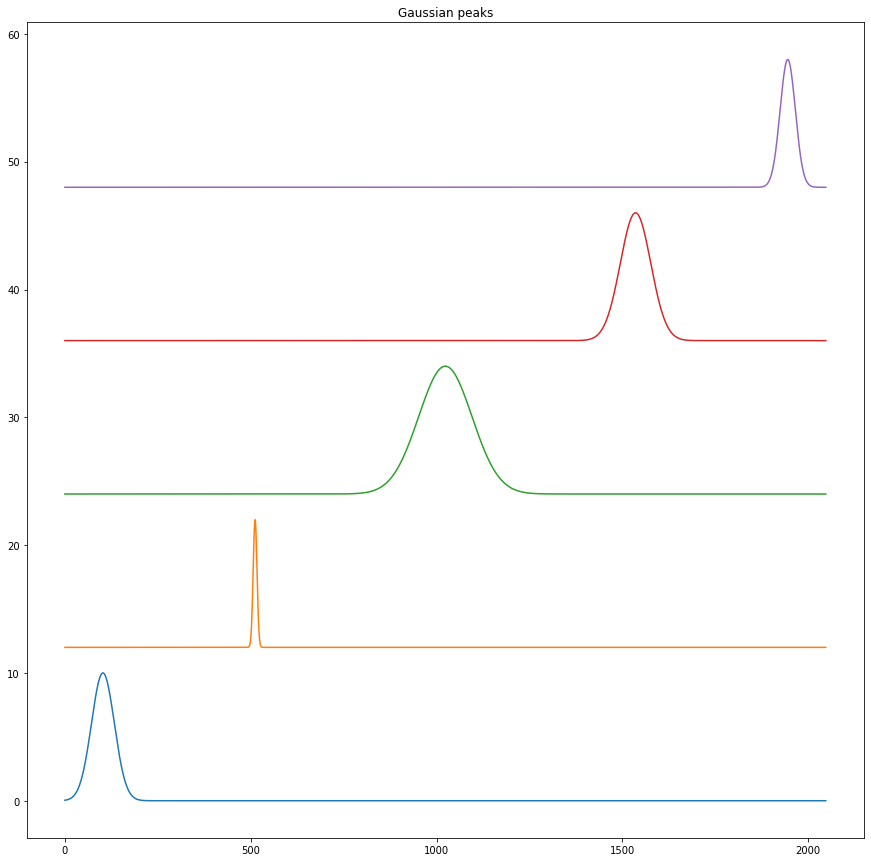

In [30]:
fig, a = plt.subplots()
fig.set_size_inches(15, 15)
a.set_title("Gaussian peaks")
for i in range(peaks.shape[0]):
    a.plot(peaks[i,:]+12.*i)
    

## Plot the sources

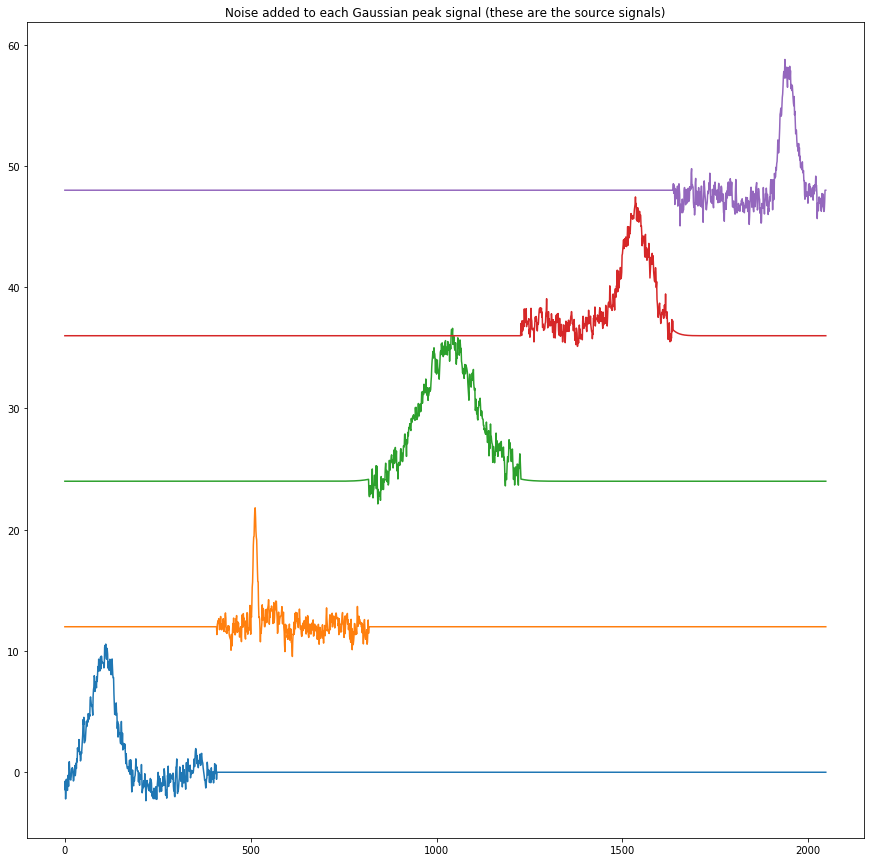

In [31]:
fig, a = plt.subplots()
fig.set_size_inches(15, 15)
a.set_title("Noise added to each Gaussian peak signal (these are the source signals)")
for i in range(sig.shape[0]):
    a.plot(sig[i,:]+12.*i)
    

## Preprocess the fields

In [32]:
# mix_signal = np.empty((num_samples, size_field))
# for i in range(num_samples):
#     # Sample 1
#     sample_pre = mix_signal_pre[i, :]
#     print(mix_signal_pre[i, :])
#     m = np.mean(sample_pre)
#     sample_ms = sample_pre - m

#     sample_ft = np.fft.fft(sample_ms)
#     sample_sqrtpower = np.absolute(sample_ft)

#     sample_ms_white_ft = sample_ft / sample_sqrtpower * (size_field**(1/2))

#     mix_signal[i] = np.fft.ifft(sample_ms_white_ft).real

# # Gaussian
# mg = np.mean(source_g)
# gauss_ms = source_g - mg

# gauss_ft = np.fft.fft(gauss_ms)
# gauss_sqrtpower = np.absolute(gauss_ft)

# gauss_ms_white_ft = gauss_ft / gauss_sqrtpower * (size_field**(1/2))

# gauss_white = np.fft.ifft(gauss_ms_white_ft).real

# # plt.figure(figsize=(18,5))
# # plt.plot(sample1)

# # plt.figure(figsize=(18,5))
# # plt.plot(sample2)

## Apply $\texttt{FastICA}$

In [33]:
ica = FastICA(n_components=num_comps, algorithm='deflation', max_iter=10000, tol=1e-4, fun='logcosh')
sl = ica.fit_transform(sig.T)

In [35]:
# Extract the individual components

# kurt_scale1 = 120
# kurt_scale2 = 900
# negen_scale1 = -120
# negen_scale2 = -900

# kurt_m1 = np.mean(sc[:, 0])
# kurt_m2 = np.mean(sc[:, 1])
# kurt_comp1 = sc[:, 0]
# kurt_comp2 = sc[:, 1]

negen_m1 = np.mean(sl[:, 0])
negen_m2 = np.mean(sl[:, 1])
negen_comp1 = sl[:, 0]
negen_comp2 = sl[:, 1]
negen_comp3 = sl[:, 2]
negen_comp4 = sl[:, 3]
negen_comp5 = sl[:, 4]
negen_sig = negen_comp1 + negen_comp2 + negen_comp3 + negen_comp4 + negen_comp5
negen_sig.size, (source_signal-g).size


(2048, 2048)

## Plot extracted signals

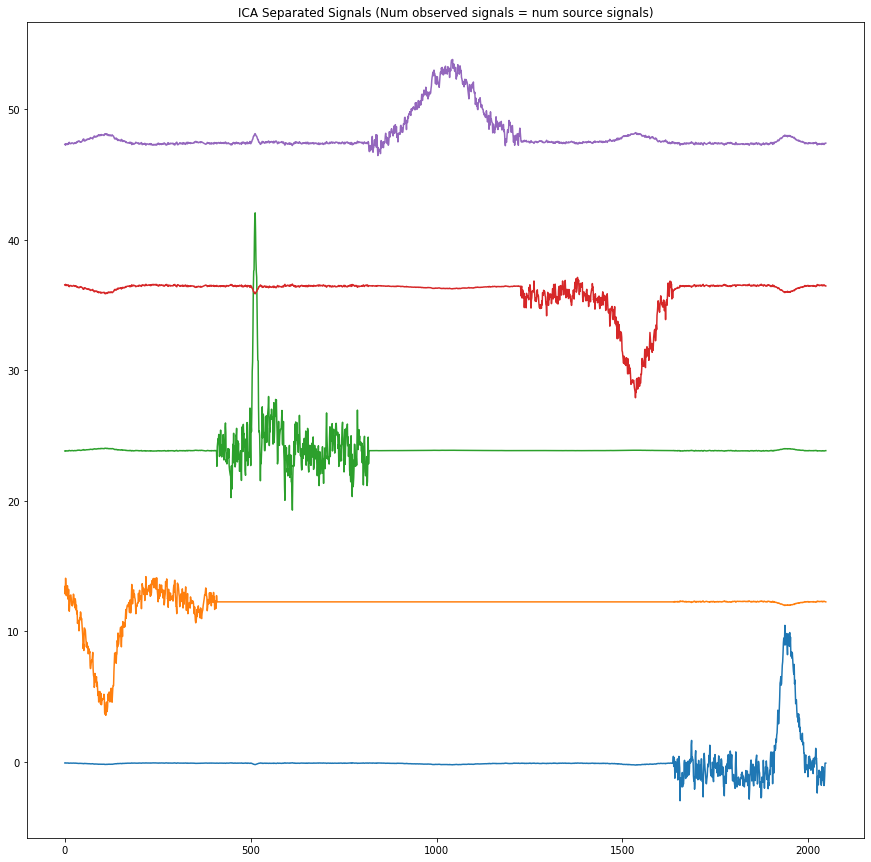

In [39]:
# Negentropy plots

fig, a = plt.subplots()
fig.set_size_inches(15, 15)
a.set_title("ICA Separated Signals (Num observed signals = num source signals)")
for i in range(sl.shape[-1]):
    a.plot(sl[:,i]*60+12*i)

# if correlated:
#     plt.savefig('ICA_corr_negentropy.png')
# else:
#     plt.savefig('ICA_uncorr_negentropy.png')

## Plot scatter of source and extracted NG 

Text(0, 0.5, 'Extracted $\\zeta_{NG}$')

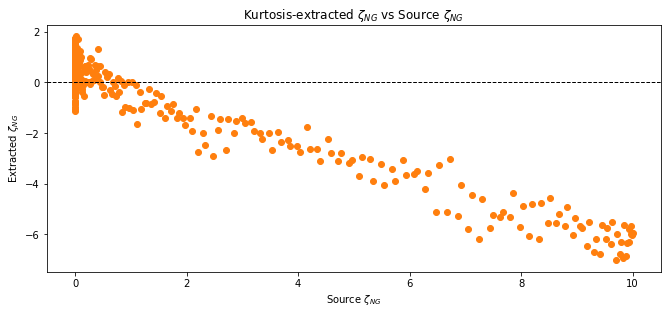

In [40]:
plt.figure(figsize=(11,10))

plt.subplot(211)
plt.axhline(color='black', ls='--', linewidth=1)
plt.scatter(peaks[0,:], sl[:,1]*50, color='C1')
plt.title(r'Kurtosis-extracted $\zeta_{NG}$ vs Source $\zeta_{NG}$')
plt.xlabel(r'Source $\zeta_{NG}$')
plt.ylabel(r'Extracted $\zeta_{NG}$')
# plt.ylim(-0.01, 0.02) 


# # plt.subplot(212)
# plt.axhline(color='black', ls='--', linewidth=1)
# plt.scatter(source_ng, negen_comp1, color='C2')
# plt.title(r'ICA-separated $\zeta_{{NG}}$ vs Source $\zeta_{{NG}}$ Using Negentropy ({0} NG Case)'.format(t))
# plt.xlabel(r'Source $\zeta_{NG}$')
# plt.ylabel(r'Extracted $\zeta_{NG}$')
# # plt.ylim(-0.01, 0.02) 

# if correlated:
#     plt.savefig('ICA_corr_scatter.png')
# else:
#     plt.savefig('ICA_uncorr_scatter.png')